# Importing Libraries

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import pandas as pd
import plotly.express as px

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics  import f1_score,accuracy_score
from sklearn.metrics import  confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from nltk.stem import PorterStemmer

# Splitting of Data

In [5]:
#importing the csv files downloaded from Kaggle
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [6]:
df_combined = pd.concat([df_train, df_test], ignore_index=True)

#Combined data set split in 80:20 ratio for train and test respectively
#stratify set on Class Index to ensure even distribution of the target class
df_train, df_test = train_test_split(df_combined, test_size=0.20, random_state=42,stratify=df_combined['Class Index'])

# Printing shape of the new train and test file
print(df_train.shape)
print(df_test.shape)

(102080, 3)
(25520, 3)


# Exploratory Data Analysis

In [7]:
# merging train and test dataframe for EDA
data = pd.merge(df_train, df_test, how = 'outer')
# Cross-checking the type of the Variable
type(data)

pandas.core.frame.DataFrame

In [6]:
data.head(10)

,Class Index,Title,Description
0,2,"Liverpool completes signings of Alonso, Garcia","LIVERPOOL, England (AP) -- Spanish pair Xabi A..."
1,2,Can US salvage a bronze?,The game was concocted by a physical education...
2,3,Breaking Rules and Saving Lives,Cord blood offers an ethical means of using st...
3,4,News: Boom times ahead for IT security profession,Boom times are ahead for security pros. The in...
4,1,Prosecutors Drop Sex Case Against Bryant,"EAGLE, Colo. - The criminal case against Kobe ..."
5,1,Georgian troops pull out from conflict zone af...,"MOSCOW, Aug. 20 (Xinhuanet) -- All Georgian tr..."
6,3,China to 'phase out' measures aimed at cooling...,AFP - China will phase out measures aimed at r...
7,3,Sony and Samsung to Cross-License Patents,TOKYO (Reuters) - Sony Corp. and Samsung Elec...
8,1,Australian FM plays down Poland's announcement...,AFP - Foreign Minister Alexander Downer has de...
9,2,Seminoles Finally Fall Off Upset #39;s Edge,The Maryland offense finally found its rhythm....


In [7]:
# change the news class type from numeric to string

data['Class Index'] =data['Class Index'].replace([1, 2, 3, 4], ['World', 'Sports', 'Business', 'Sci/Tech'])

In [8]:
data.describe(include='all')

,Class Index,Title,Description
count,127600,127600,127600
unique,4,121258,126182
top,Sports,Today's schedule,"With the economy slowly turning up, upgrading ..."
freq,31900,43,16


In [9]:
# counts of rows and columns
rows = len(data.axes[0])
cols = len(data.axes[1])
print('Total Columns in the Corpus:', cols)
print('Total Entries in the Corpus :', rows)

Total Columns in the Corpus: 3
Total Entries in the Corpus : 127600


In [10]:
#Calculating the occurences of the Different classes
print('Occourences of Different Class')
data['Class Index'].value_counts()

Occourences of Different Class


Sports      31900
Business    31900
Sci/Tech    31900
World       31900
Name: Class Index, dtype: int64

In [ ]:
# Visualization of Different Classes
fig = px.pie(data_frame = data, names = 'Class Index', hole = 0.5, title = 'News Classification',
             width = 640, height = 480, color_discrete_sequence = px.colors.sequential.Bluered)
fig.update_layout(title_x = 0.5, uniformtext_minsize = 30)
fig.show()

In [ ]:
# check the duplicate combinations of News Articles (title and description together)
dup = data[['Title', 'Description']].duplicated().sum()
print('Number of duplicate values:', dup)

Number of duplicate values: 0


In [ ]:
# check the null values for data
print('Checking for null values')
data.isnull().sum()

Checking for null values


Class Index    0
Title          0
Description    0
dtype: int64

In [11]:
#concatenating Title and Description
data['test_string'] = data['Title'] + " " + data['Description']

In [12]:
data.head(10)

,Class Index,Title,Description,test_string
0,Sports,"Liverpool completes signings of Alonso, Garcia","LIVERPOOL, England (AP) -- Spanish pair Xabi A...","Liverpool completes signings of Alonso, Garcia..."
1,Sports,Can US salvage a bronze?,The game was concocted by a physical education...,Can US salvage a bronze? The game was concocte...
2,Business,Breaking Rules and Saving Lives,Cord blood offers an ethical means of using st...,Breaking Rules and Saving Lives Cord blood off...
3,Sci/Tech,News: Boom times ahead for IT security profession,Boom times are ahead for security pros. The in...,News: Boom times ahead for IT security profess...
4,World,Prosecutors Drop Sex Case Against Bryant,"EAGLE, Colo. - The criminal case against Kobe ...",Prosecutors Drop Sex Case Against Bryant EAGLE...
5,World,Georgian troops pull out from conflict zone af...,"MOSCOW, Aug. 20 (Xinhuanet) -- All Georgian tr...",Georgian troops pull out from conflict zone af...
6,Business,China to 'phase out' measures aimed at cooling...,AFP - China will phase out measures aimed at r...,China to 'phase out' measures aimed at cooling...
7,Business,Sony and Samsung to Cross-License Patents,TOKYO (Reuters) - Sony Corp. and Samsung Elec...,Sony and Samsung to Cross-License Patents TOK...
8,World,Australian FM plays down Poland's announcement...,AFP - Foreign Minister Alexander Downer has de...,Australian FM plays down Poland's announcement...
9,Sports,Seminoles Finally Fall Off Upset #39;s Edge,The Maryland offense finally found its rhythm....,Seminoles Finally Fall Off Upset #39;s Edge Th...


In [13]:
#Counting number of characters in each message
data['char'] = data['test_string'].apply(len)
#Counting number of words in each message
data['word'] = data.apply(lambda row: nltk.word_tokenize(row['test_string']), axis=1).apply(len)
#Counting number of sentences in each message.
data['sentence'] = data.apply(lambda row: nltk.sent_tokenize(row['test_string']), axis=1).apply(len)

data.describe()

,char,word,sentence
count,127600.000000,127600.000000,127600.000000
mean,236.390361,43.925039,1.320940
std,66.457496,13.471391,0.661321
min,17.000000,6.000000,1.000000
25%,196.000000,36.000000,1.000000
50%,232.000000,43.000000,1.000000
75%,266.000000,50.000000,1.000000
max,1012.000000,249.000000,15.000000


In [ ]:
data.head(10)

,Class Index,Title,Description,test_string,char,word,sentence
0,Sports,"Liverpool completes signings of Alonso, Garcia","LIVERPOOL, England (AP) -- Spanish pair Xabi A...","Liverpool completes signings of Alonso, Garcia...",202,34,1
1,Sports,Can US salvage a bronze?,The game was concocted by a physical education...,Can US salvage a bronze? The game was concocte...,180,33,2
2,Business,Breaking Rules and Saving Lives,Cord blood offers an ethical means of using st...,Breaking Rules and Saving Lives Cord blood off...,103,19,1
3,Sci/Tech,News: Boom times ahead for IT security profession,Boom times are ahead for security pros. The in...,News: Boom times ahead for IT security profess...,207,37,2
4,World,Prosecutors Drop Sex Case Against Bryant,"EAGLE, Colo. - The criminal case against Kobe ...",Prosecutors Drop Sex Case Against Bryant EAGLE...,261,45,1
5,World,Georgian troops pull out from conflict zone af...,"MOSCOW, Aug. 20 (Xinhuanet) -- All Georgian tr...",Georgian troops pull out from conflict zone af...,291,47,1
6,Business,China to 'phase out' measures aimed at cooling...,AFP - China will phase out measures aimed at r...,China to 'phase out' measures aimed at cooling...,224,45,1
7,Business,Sony and Samsung to Cross-License Patents,TOKYO (Reuters) - Sony Corp. and Samsung Elec...,Sony and Samsung to Cross-License Patents TOK...,269,45,1
8,World,Australian FM plays down Poland's announcement...,AFP - Foreign Minister Alexander Downer has de...,Australian FM plays down Poland's announcement...,294,53,1
9,Sports,Seminoles Finally Fall Off Upset #39;s Edge,The Maryland offense finally found its rhythm....,Seminoles Finally Fall Off Upset #39;s Edge Th...,219,46,4


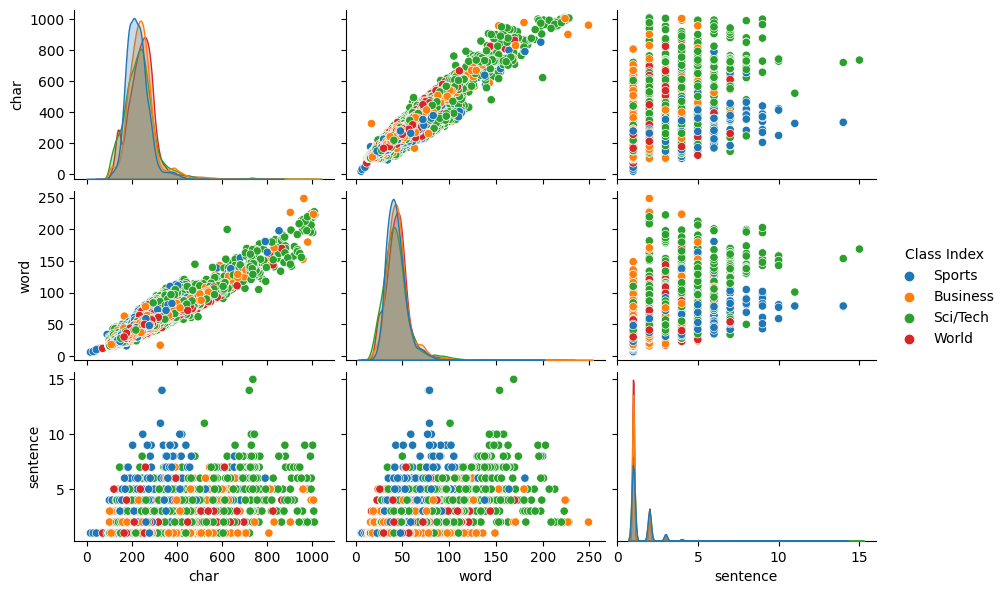

In [ ]:
#Visualization for Pairplot of number of words, sentences , and messages
fig = sns.pairplot(data = data, hue = 'Class Index', height = 2, aspect = 1.5)
plt.show(fig)


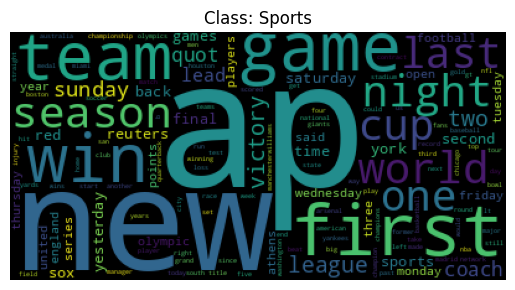

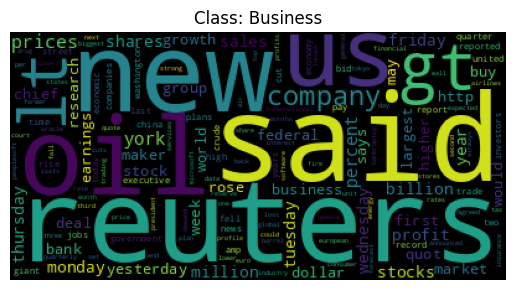

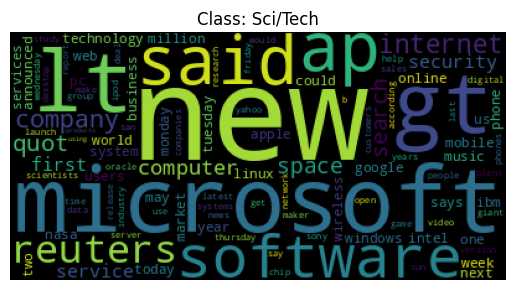

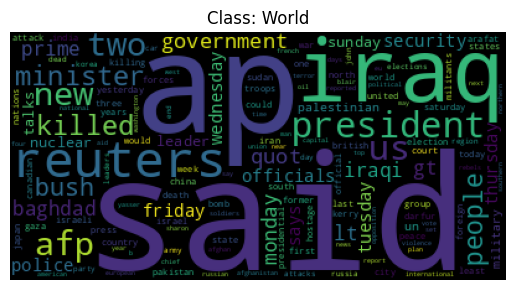

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming your corpus is stored in a DataFrame 'data' with a column 'class' indicating the class labels

classes = data['Class Index'].unique()  # Get all unique class labels

for class_label in classes:
    class_data = data[data['Class Index'] == class_label]['test_string']  # Filter data for the current class

    words_dict = {}  # Initialize an empty dictionary to store words and their frequencies for the current class

    for message in class_data:
        words = [word.lower() for word in word_tokenize(message) if word.lower() not in stopwords.words('english') and word.lower().isalpha()]

        for word in words:
            if word in words_dict:
                words_dict[word] += 1
            else:
                words_dict[word] = 1

    # Generate a word cloud for the current class
    word_cloud = WordCloud().generate_from_frequencies(words_dict)

    # Create a figure and an axis
    fig, ax = plt.subplots()

    # Display the word cloud
    ax.imshow(word_cloud)

    # Set the axis limits
    ax.set_axis_off()

    # Set the title for the current class
    ax.set_title(f'Class: {class_label}')

    # Show the word cloud
    plt.show()


<ipython-input-20-75040ba2a292>:6: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-20-75040ba2a292>:9: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-20-75040ba2a292>:12: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use e

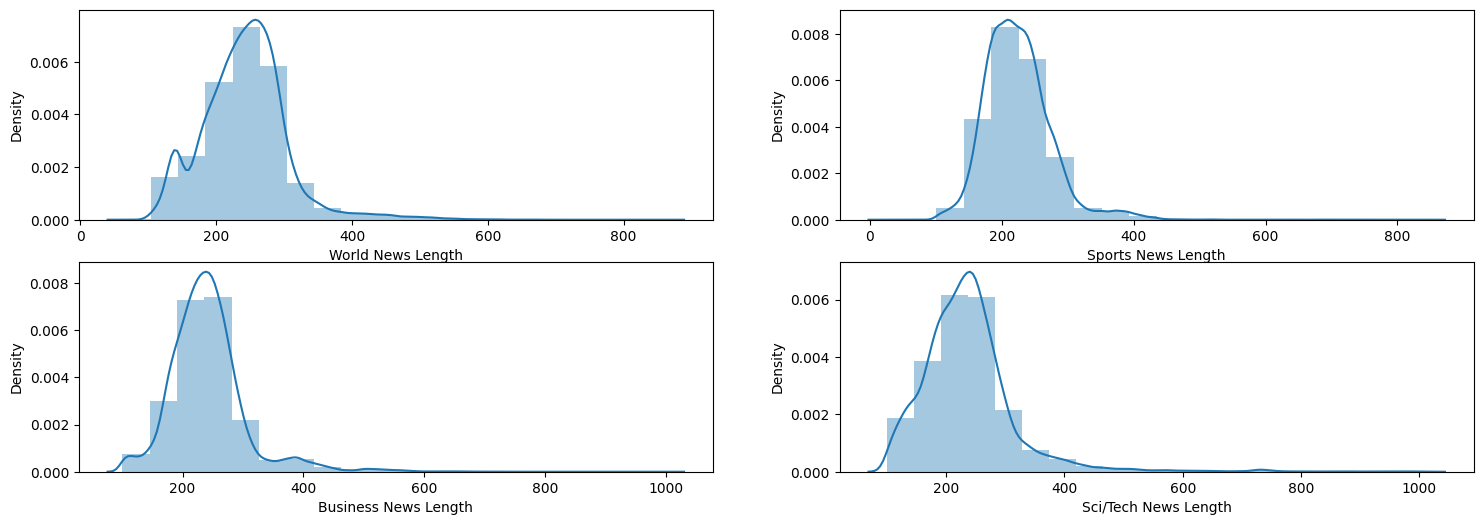

In [ ]:
data['string_len'] = data['test_string'].apply(len)
data['string_len'].describe()

f, ax = plt.subplots(2, 2, figsize = (18, 6))

sns.distplot(data[data['Class Index'] == 'World']['string_len'], bins = 20, ax = ax[0,0])
ax[0,0].set_xlabel('World News Length')

sns.distplot(data[data['Class Index'] == 'Sports']['string_len'], bins = 20, ax = ax[0,1])
ax[0,1].set_xlabel('Sports News Length')

sns.distplot(data[data['Class Index'] == 'Business']['string_len'], bins = 20, ax = ax[1,0])
ax[1,0].set_xlabel('Business News Length')

sns.distplot(data[data['Class Index'] == 'Sci/Tech']['string_len'], bins = 20, ax = ax[1,1])
ax[1,1].set_xlabel('Sci/Tech News Length')

plt.show()

# DATA PRE-PROCESSING

In [8]:
#working on the train and test split by concatenating Title and Description
df_train['X_train'] = df_train['Title'] + " " + df_train['Description']
df_train['y_train'] = df_train['Class Index'].apply(lambda x: x-1).values
df_test['X_test'] = df_test['Title'] + " " + df_test['Description']
df_test['y_test'] = df_test['Class Index'].apply(lambda x: x-1).values

In [9]:
def clean_and_tokenize(text):
  """
  Preprocesses text by lowercasing, removing HTML tags, punctuation, numbers, and tokenizing.

  Args:
    text: String containing the text to be cleaned.

  Returns:
    List of tokens from the cleaned text.
  """
  text = text.lower()
  text = re.sub('<.*?>', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\w*\d\w*', '', text)
  return word_tokenize(text)

def stem_and_join(tokens):
  """
  Applies stemming to a list of tokens and joins them back into a string.

  Args:
    tokens: List of tokens to be stemmed.

  Returns:
    String with the stemmed tokens joined together.
  """
  stemmer = PorterStemmer()
  stemmed_tokens = [stemmer.stem(word) for word in tokens]
  return ' '.join(stemmed_tokens)

def lemmatize_and_join(tokens):
  """
  Applies lemmatization to a list of tokens and joins them back into a string.

  Args:
    tokens: List of tokens to be lemmatized.

  Returns:
    String with the lemmatized tokens joined together.
  """
  stop_words = set(stopwords.words('english'))
  filtered_tokens = [word for word in tokens if word not in stop_words]
  lemmatizer = WordNetLemmatizer()
  lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_tokens]
  return ' '.join(lemmatized_text)

In [10]:
def apply_tfidf_varied_features(max_features_array, df_train_column, df_test_column):
    # Store the results in a dictionary
    results = {}

    # Iterate through the array of max feature numbers
    for max_features in max_features_array:


        # Initialize the TfidfVectorizer
        tfidf = TfidfVectorizer(max_features=max_features, min_df=6)

        # Fit and transform on training data
        tfidf_features = tfidf.fit_transform(df_train_column)
        # Transform the testing data
        test_tfidf_features = tfidf.transform(df_test_column)

        # Convert to dense arrays
        train_array = tfidf_features.toarray()
        test_array = test_tfidf_features.toarray()

        # Store the results
        results[max_features] = {
            "train_array": train_array,
            "test_array": test_array
        }

    return results

In [11]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [12]:
#Applying clean and tokenization to the X_train column

df_train['clean_text'] = df_train['X_train'].apply(clean_and_tokenize)
df_train['stemmed_text'] = df_train['clean_text'].apply(stem_and_join)
df_train['lemmatized_text'] = df_train['clean_text'].apply(lemmatize_and_join)

df_test['clean_text'] = df_test['X_test'].apply(clean_and_tokenize)
df_test['stemmed_text'] = df_test['clean_text'].apply(stem_and_join)
df_test['lemmatized_text'] = df_test['clean_text'].apply(lemmatize_and_join)

In [13]:
result_lem = apply_tfidf_varied_features((5000,10000,15000,20000), df_train['lemmatized_text'], df_test['lemmatized_text'])
result_stem = apply_tfidf_varied_features((5000,10000,15000,20000), df_train['stemmed_text'], df_test['stemmed_text'])

# MODEL IMPLEMENTATION

## NAIVE BAYES

In [14]:
def evaluate_naive_bayes_classifier(result, df_train, df_test):
    best_accuracy = 0
    accuracies = []

    for max_features, data in result.items():
        # Extract train and test arrays
        train_array = data['train_array']
        test_array = data['test_array']
        y_train = df_train['y_train']
        y_test = df_test['y_test']

        # Train Naive Bayes classifier
        clf = MultinomialNB()
        clf.fit(train_array, y_train)

        # Predict on the test set and calculate accuracy
        predictions = clf.predict(test_array)
        accuracy = accuracy_score(y_test, predictions)
        accuracies.append(accuracy)

        # Update best model if current model has higher accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = clf
            best_predictions = clf.predict(test_array)
            best_max_features = max_features

    # Plotting results
    plt.figure(figsize=(10, 6))
    plt.plot(list(result_lem.keys()), accuracies, marker='o')
    plt.xlabel('Max Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Max Features in Naive Bayes Classifier')
    plt.grid(True)
    plt.show()

    return best_max_features, best_accuracy, best_model, best_predictions

In [15]:
def eval_model(y,y_pred):
    print("F1 score of the model")
    print(f1_score(y,y_pred,average='weighted'))
    print("Accuracy of the model")
    print(accuracy_score(y,y_pred))
    print("Accuracy of the model in percentage")
    print(round(accuracy_score(y,y_pred)*100,3),"%")

In [16]:
def confusion_mat(color,predictions):
    cof=confusion_matrix(df_test['y_test'], predictions)
    cof=pd.DataFrame(cof, index=[i for i in range(1,5)], columns=[i for i in range(1,5)])
    sns.set(font_scale=1.5)
    plt.figure(figsize=(8,8));

    sns.heatmap(cof, cmap=color,linewidths=1, annot=True,square=True, fmt='d', cbar=False,xticklabels=['World','Sports','Business','Science'],yticklabels=['World','Sports','Business','Science']);
    plt.xlabel("Predicted Classes");
    plt.ylabel("Actual Classes");

### For Lemmatization

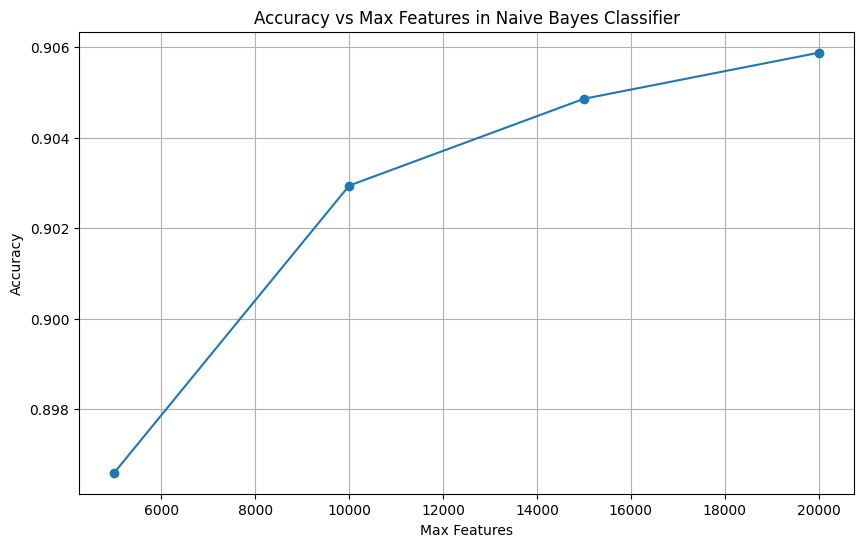

Best max_features: 20000 with accuracy: 0.9058777429467084


In [17]:
#Plotting Graph for the Accuracy for different Features selected
best_max_features_lem, best_accuracy_lem, best_model_lem,best_predictions_lem = evaluate_naive_bayes_classifier(result_lem, df_train, df_test)
print(f"Best max_features: {best_max_features_lem} with accuracy: {best_accuracy_lem}")

In [18]:
#F1-Score and Accuracy of the Model
eval_model(df_test['y_test'],best_predictions_lem)

F1 score of the model
0.9056502366207753
Accuracy of the model
0.9058777429467084
Accuracy of the model in percentage
90.588 %


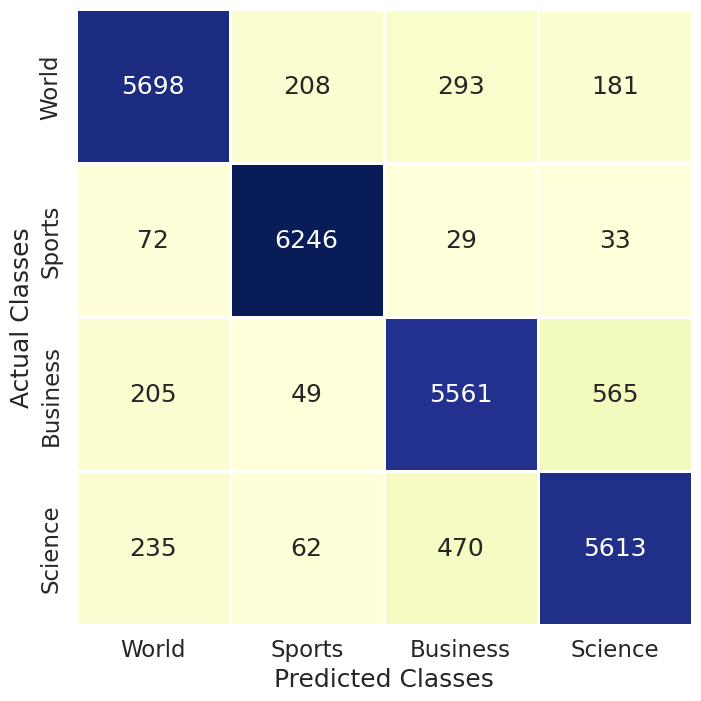

In [19]:
# Creation of Confusion Matrix for Naive Bayes Lemmatization
confusion_mat('YlGnBu',best_predictions_lem)

### For Stemming

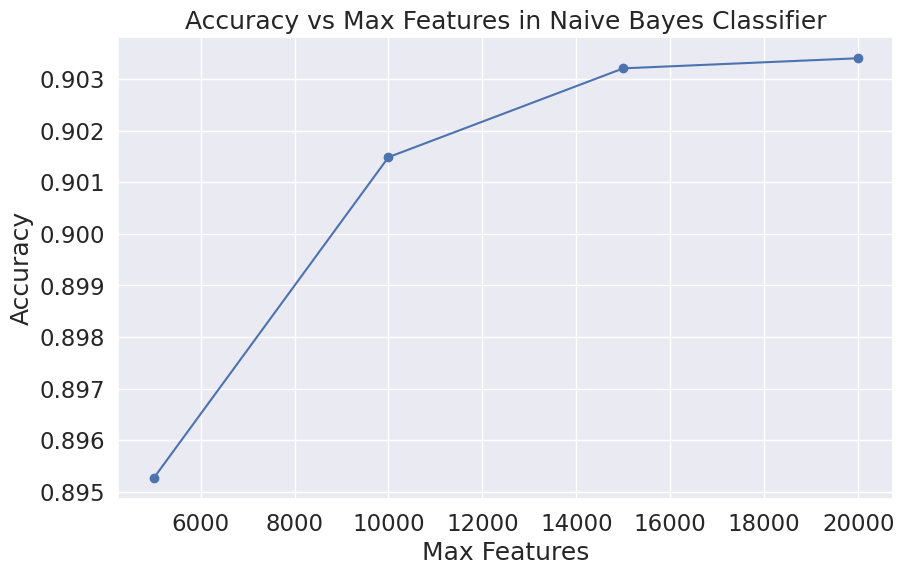

Best max_features: 20000 with accuracy: 0.9034090909090909


In [20]:
#Plotting Graph for the Accuracy for different Features selected
best_max_features_stem, best_accuracy_stem, best_model_stem,best_predictions_stem = evaluate_naive_bayes_classifier(result_stem, df_train, df_test)
print(f"Best max_features: {best_max_features_stem} with accuracy: {best_accuracy_stem}")

In [21]:
#F1-Score and Accuracy of the Model
eval_model(df_test['y_test'],best_predictions_stem)

F1 score of the model
0.9031510471274861
Accuracy of the model
0.9034090909090909
Accuracy of the model in percentage
90.341 %


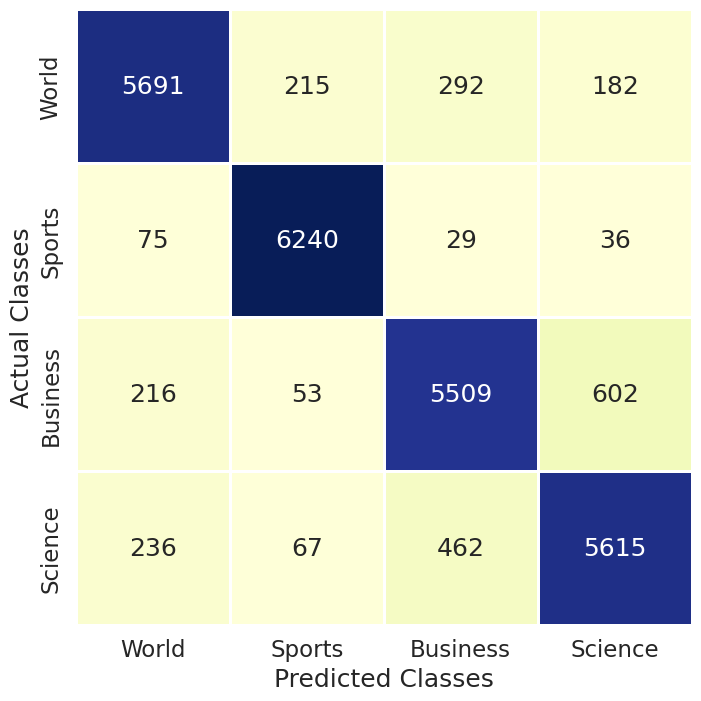

In [22]:
# Creation of Confusion Matrix for Naive Bayes Stemming
confusion_mat('YlGnBu',best_predictions_stem)

## LONG SHORT-TERM MEORY NETWORK

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical

### For Stemming

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_train['stemmed_text'])
sequences = tokenizer.texts_to_sequences(df_train['stemmed_text'])
X_train = pad_sequences(sequences, maxlen=500)
y_train = to_categorical(df_train['y_train'])
test_sequences = tokenizer.texts_to_sequences(df_test['stemmed_text'])
X_test = pad_sequences(test_sequences, maxlen=500)
y_test = to_categorical(df_test['y_test'])

In [ ]:
model = Sequential()
model.add(Embedding(5000, 128, input_length=500))
model.add(LSTM(128, dropout=0.2))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs=3, validation_split=0.1)

Epoch 1/3
718/718 [==============================] - 42s 46ms/step - loss: 0.4226 - accuracy: 0.8504 - val_loss: 0.2950 - val_accuracy: 0.9025
Epoch 2/3
718/718 [==============================] - 21s 29ms/step - loss: 0.2545 - accuracy: 0.9158 - val_loss: 0.2833 - val_accuracy: 0.9058
Epoch 3/3
718/718 [==============================] - 20s 28ms/step - loss: 0.2285 - accuracy: 0.9233 - val_loss: 0.2850 - val_accuracy: 0.9052


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

798/798 [==============================] - 8s 10ms/step - loss: 0.2711 - accuracy: 0.9101
Test Accuracy: 91.01%


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
eval_model(y_true,y_pred_classes)

798/798 [==============================] - 7s 8ms/step
F1 score of the model
0.9100953021487508
Accuracy of the model
0.9101489028213167
Accuracy of the model in percentage
91.015 %


"\ny_pred_classes = np.argmax(y_pred, axis=1)\ny_true = np.argmax(y_test, axis=1)\n\ncm = confusion_matrix(y_true, y_pred_classes)\nplt.figure(figsize=(10, 8))\nsns.heatmap(cm, annot=True, fmt='d', cmap='Blues')\nplt.ylabel('True Label')\nplt.xlabel('Predicted Label')\nplt.title('Confusion Matrix')\nplt.show()\n"

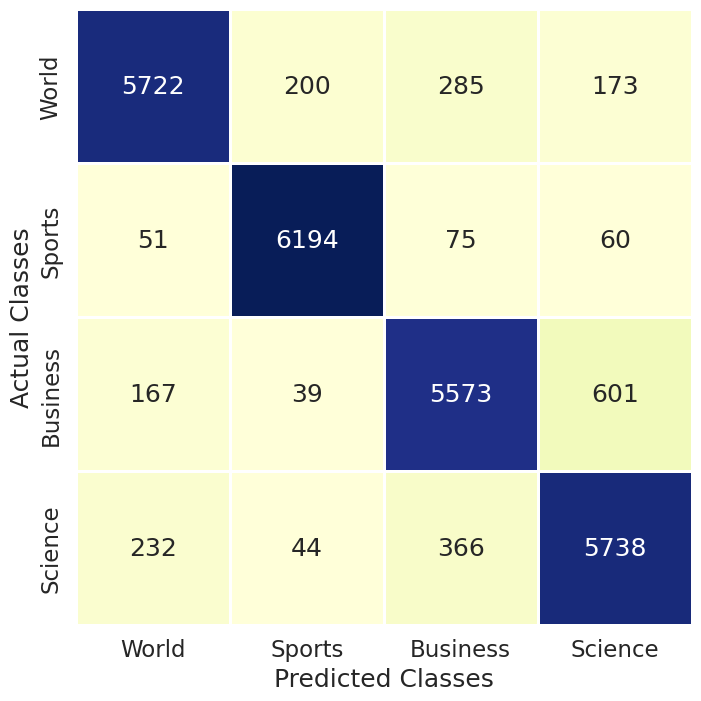

In [ ]:
confusion_mat('YlGnBu',y_pred_classes)

'''
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()
'''

### For Lemmatization

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_train['lemmatized_text'])
sequences = tokenizer.texts_to_sequences(df_train['lemmatized_text'])
X_train = pad_sequences(sequences, maxlen=500)
y_train = to_categorical(df_train['y_train'])
test_sequences = tokenizer.texts_to_sequences(df_test['lemmatized_text'])
X_test = pad_sequences(test_sequences, maxlen=500)
y_test = to_categorical(df_test['y_test'])

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs=3, validation_split=0.1)

Epoch 1/3
718/718 [==============================] - 34s 47ms/step - loss: 0.4316 - accuracy: 0.8421 - val_loss: 0.2799 - val_accuracy: 0.9048
Epoch 2/3
718/718 [==============================] - 20s 28ms/step - loss: 0.2440 - accuracy: 0.9176 - val_loss: 0.2823 - val_accuracy: 0.9052
Epoch 3/3
718/718 [==============================] - 20s 28ms/step - loss: 0.2133 - accuracy: 0.9263 - val_loss: 0.2789 - val_accuracy: 0.9050


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

798/798 [==============================] - 8s 11ms/step - loss: 0.2666 - accuracy: 0.9107
Test Accuracy: 91.07%


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
eval_model(y_true,y_pred_classes)

798/798 [==============================] - 6s 8ms/step
F1 score of the model
0.9105404013578001
Accuracy of the model
0.9106974921630094
Accuracy of the model in percentage
91.07 %


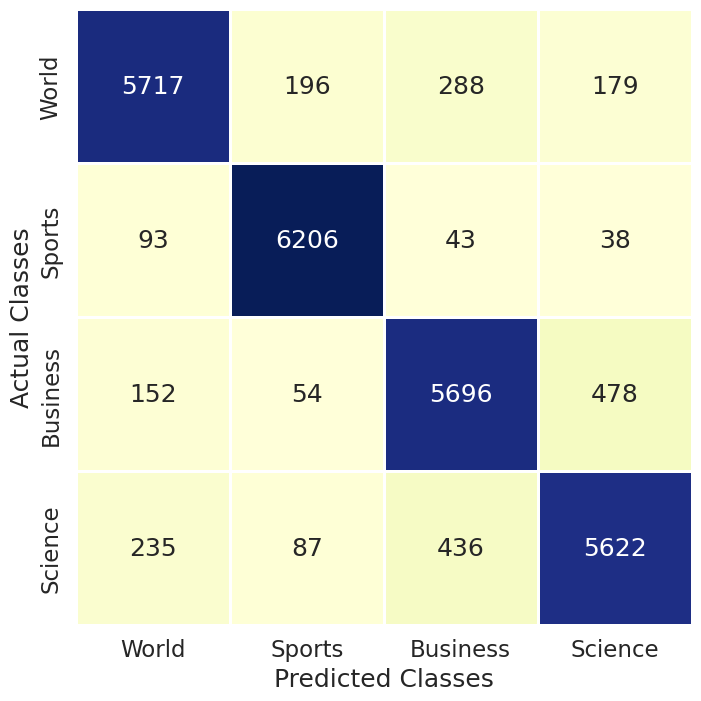

In [ ]:
confusion_mat('YlGnBu',y_pred_classes)

## BIDIRECTIONAL ENCODER REPRESENTATIONS FROM TRANSFORMERS

### For Lemmatization

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch import nn, optim
import torch

# Assuming you have a DataFrame 'train_df' with columns 'lemmatized_text' and 'y_train'

# Split the data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    df_train['lemmatized_text'], df_train['y_train'], test_size=0.2, random_state=42
)

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df_train['y_train'].unique()))

# Tokenize the input data
train_tokens = tokenizer(list(train_data), padding=True, truncation=True, return_tensors='pt')
val_tokens = tokenizer(list(val_data), padding=True, truncation=True, return_tensors='pt')

# Create PyTorch Dataset
class NewsDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokens['input_ids'][idx],
            'attention_mask': self.tokens['attention_mask'][idx],
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

train_dataset = NewsDataset(train_tokens, train_labels)
val_dataset = NewsDataset(val_tokens, val_labels)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define training parameters
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluate on the validation set
    model.eval()
    val_predictions = []
    val_true_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            _, predictions = torch.max(logits, dim=1)

            val_predictions.extend(predictions.cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy_val = accuracy_score(val_true_labels, val_predictions)
    conf_matrix_val = confusion_matrix(val_true_labels, val_predictions)
    classification_report_val = classification_report(val_true_labels, val_predictions)

    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {accuracy_val}")
    print(f"Confusion Matrix (Validation):\n{conf_matrix_val}")
    print(f"Classification Report (Validation):\n{classification_report_val}")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Validation Accuracy: 0.9302507836990596
Confusion Matrix (Validation):
[[4846  111  131  129]
 [  23 5033    7   16]
 [ 186   30 4413  345]
 [ 114   28  304 4700]]
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      5217
           1       0.97      0.99      0.98      5079
           2       0.91      0.89      0.90      4974
           3       0.91      0.91      0.91      5146

    accuracy                           0.93     20416
   macro avg       0.93      0.93      0.93     20416
weighted avg       0.93      0.93      0.93     20416

Epoch 2/5, Validation Accuracy: 0.9344631661442007
Confusion Matrix (Validation):
[[4866   83  170   98]
 [  16 5020   35    8]
 [ 115   18 4572  269]
 [ 145   16  365 4620]]
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      5217
           1       0.98      0.99 

In [ ]:
def confusion_mat(color,true_label,predictions):
    cof=confusion_matrix(true_label, predictions)
    cof=pd.DataFrame(cof, index=[i for i in range(1,5)], columns=[i for i in range(1,5)])
    sns.set(font_scale=1.5)
    plt.figure(figsize=(8,8));

    sns.heatmap(cof, cmap=color,linewidths=1, annot=True,square=True, fmt='d', cbar=False,xticklabels=['World','Sports','Business','Science'],yticklabels=['World','Sports','Business','Science']);
    plt.xlabel("Predicted Classes");
    plt.ylabel("Actual Classes");

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


F1 score of the model
0.9300009551251954
Accuracy of the model
0.9300940438871473
Accuracy of the model in percentage
93.009 %


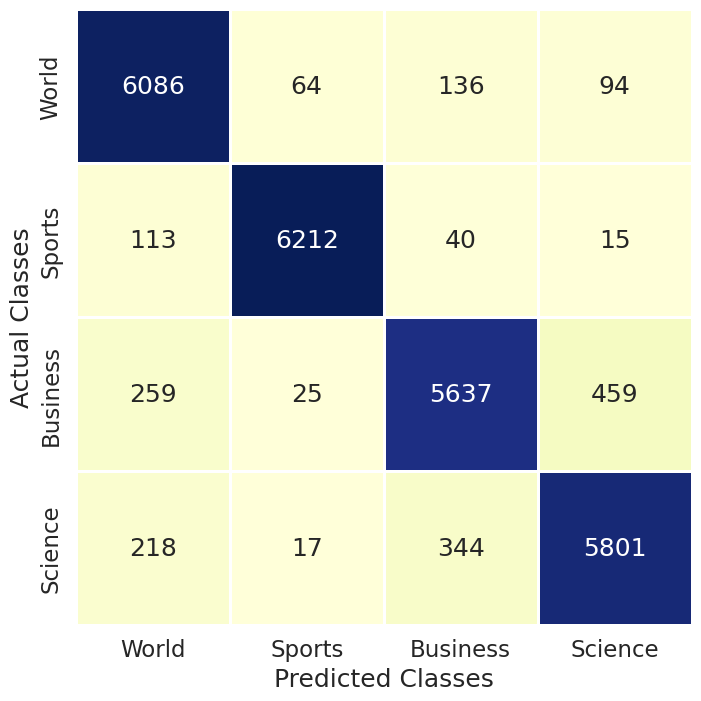

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the saved model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
model.load_state_dict(torch.load('/content/drive/MyDrive/bert_model_lem.pth'))
model.eval()

# Assuming you have a DataFrame 'test_df' with columns 'lemmatized_text' and 'y_test'

# Tokenize the test data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
test_tokens = tokenizer(list(df_test['lemmatized_text']), padding=True, truncation=True, return_tensors='pt')

# Create PyTorch Dataset for test data
class NewsDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokens['input_ids'][idx],
            'attention_mask': self.tokens['attention_mask'][idx],
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

test_dataset = NewsDataset(test_tokens, df_test['y_test'])

# Create DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model on test data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        _, predictions = torch.max(logits, dim=1)

        test_predictions.extend(predictions.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

# Calculate test metrics

eval_model(test_true_labels, test_predictions)
confusion_mat('YlGnBu',test_true_labels,test_predictions)

### For Stemming

In [ ]:


# Assuming you have a DataFrame 'train_df' with columns 'stemmed_text' and 'y_train'

# Split the data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    df_train['stemmed_text'], df_train['y_train'], test_size=0.2, random_state=42
)

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df_train['y_train'].unique()))

# Tokenize the input data
train_tokens = tokenizer(list(train_data), padding=True, truncation=True, return_tensors='pt')
val_tokens = tokenizer(list(val_data), padding=True, truncation=True, return_tensors='pt')

# Create PyTorch Dataset
class NewsDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokens['input_ids'][idx],
            'attention_mask': self.tokens['attention_mask'][idx],
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

train_dataset = NewsDataset(train_tokens, train_labels)
val_dataset = NewsDataset(val_tokens, val_labels)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define training parameters
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluate on the validation set
    model.eval()
    val_predictions = []
    val_true_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            _, predictions = torch.max(logits, dim=1)

            val_predictions.extend(predictions.cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy_val = accuracy_score(val_true_labels, val_predictions)
    conf_matrix_val = confusion_matrix(val_true_labels, val_predictions)
    classification_report_val = classification_report(val_true_labels, val_predictions)

    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {accuracy_val}")
    print(f"Confusion Matrix (Validation):\n{conf_matrix_val}")
    print(f"Classification Report (Validation):\n{classification_report_val}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Validation Accuracy: 0.9260384012539185
Confusion Matrix (Validation):
[[4694  131  217  175]
 [  16 5019   19   25]
 [  98   32 4401  443]
 [  79   23  252 4792]]
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      5217
           1       0.96      0.99      0.98      5079
           2       0.90      0.88      0.89      4974
           3       0.88      0.93      0.91      5146

    accuracy                           0.93     20416
   macro avg       0.93      0.93      0.93     20416
weighted avg       0.93      0.93      0.93     20416

Epoch 2/5, Validation Accuracy: 0.9321610501567398
Confusion Matrix (Validation):
[[4874   57  150  136]
 [  68 4980   11   20]
 [ 133   64 4439  338]
 [ 119   24  265 4738]]
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      5217
           1       0.97      0.98 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


F1 score of the model
0.9116894906625299
Accuracy of the model
0.911833855799373
Accuracy of the model in percentage
91.183 %


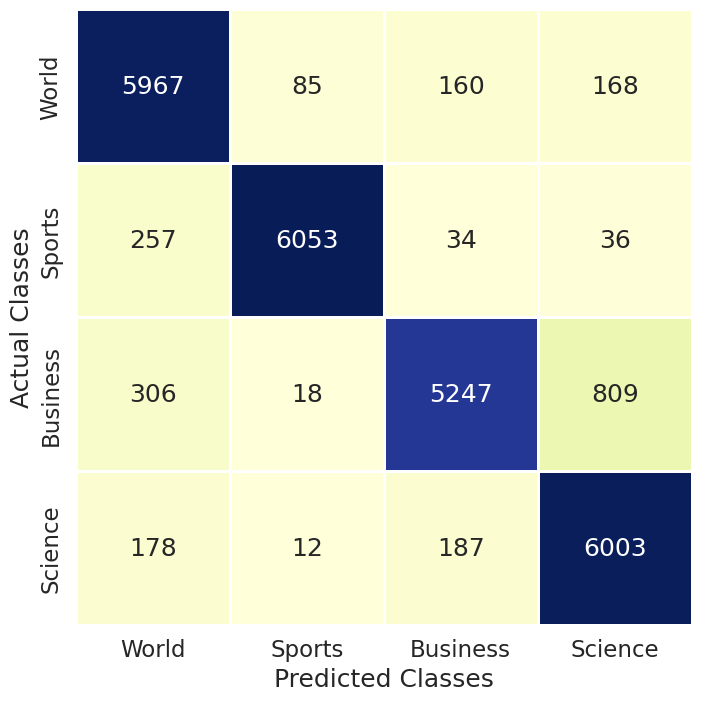

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the saved model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
model.load_state_dict(torch.load('/content/drive/MyDrive/bert_model_stem.pth'))
model.eval()

# Assuming you have a DataFrame 'test_df' with columns 'lemmatized_text' and 'y_test'

# Tokenize the test data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
test_tokens = tokenizer(list(df_test['lemmatized_text']), padding=True, truncation=True, return_tensors='pt')

# Create PyTorch Dataset for test data
class NewsDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokens['input_ids'][idx],
            'attention_mask': self.tokens['attention_mask'][idx],
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

test_dataset = NewsDataset(test_tokens, df_test['y_test'])

# Create DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model on test data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        _, predictions = torch.max(logits, dim=1)

        test_predictions.extend(predictions.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

# Calculate test metrics

eval_model(test_true_labels, test_predictions)
confusion_mat('YlGnBu',test_true_labels,test_predictions)